# predicting_vote_average.ipynb

In this notebook we will build a classification machine learning model that predicts vote_average from budget, runtime and genres.

Classification machine learning models predicts categorical values.

So we define the categorical value rating as:
- rating is "good" if vote_average ≥ 7
- rating is "ok" if 5 ≤ vote_average < 7
- rating is "bad" if vote_average < 5

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import ast  # Abstract Syntax Trees - safely parse string list to Python list
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import graphviz
import os
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
from reader import generic_reader

First we read in the movie data from `movies_clean.csv` and see that we have 6200 movies.

In [2]:
df_movies = generic_reader.read_csv_file_to_data_frame("movie_data/movies_prepared.csv")
len(df_movies)

6200

Then we choose the columns we will work in this notebook.

In [3]:
columns_to_keep = ['movie_id', 'original_title', 'budget_2023_usd', 'runtime', 'vote_average', 'genre_ids']
df_movies = df_movies[columns_to_keep].copy()
df_movies['genre_ids'] = df_movies['genre_ids'].apply(ast.literal_eval) # Turn genre_ids into actual Python list
df_movies

,movie_id,original_title,budget_2023_usd,runtime,vote_average,genre_ids
0,19214,Passion of Mind,21233560,105,5.800,"[18, 10749]"
1,17908,My Dog Skip,10616780,95,6.700,"[35, 18, 10751]"
2,10471,Next Friday,19464096,98,6.453,[35]
3,10384,Supernova,159251699,91,4.940,"[878, 27, 53]"
4,10213,From Dusk Till Dawn 3: The Hangman's Daughter,8847317,94,4.900,"[37, 27, 53]"
...,...,...,...,...,...,...
6195,850165,The Iron Claw,15900000,132,7.540,"[36, 18]"
6196,1025491,Freud's Last Session,10000000,109,6.659,[18]
6197,994108,All of Us Strangers,5000000,105,7.443,"[10749, 18, 14]"
6198,823452,The Boys in the Boat,40000000,124,7.233,"[18, 36]"


We determine the rating "good", "ok", "bad" for each movie.

In [4]:
# Define the function for determing rating from vote_average
def determine_rating(vote_average):
    if vote_average >= 7:
        return "good";
    if vote_average >= 5:
        return "ok";
    else:
        return "bad";

# Apply the function to df_movies 
df_movies['rating'] = df_movies['vote_average'].apply(determine_rating)
df_movies.sort_values(by="vote_average", ascending=False)

,movie_id,original_title,budget_2023_usd,runtime,vote_average,genre_ids,rating
3392,246895,Complacent,663566,104,9.400,[18],good
4583,631303,The Devil's Hour,145998,119,8.900,"[27, 18, 53]",good
2162,155,The Dark Knight,261816713,152,8.523,"[18, 28, 80, 53]",good
5341,554386,Evanescence: Synthesis Live,121343,88,8.500,[10402],good
4230,157336,Interstellar,212370429,169,8.500,"[12, 18, 878]",good
...,...,...,...,...,...,...,...
4235,295884,Saving Christmas,643547,79,1.800,"[35, 14]",bad
2992,118332,Total Retribution,2031893,84,1.800,"[27, 878, 53]",bad
70,203023,Witchcraft XI: Sisters in Blood,71,90,1.700,[27],bad
5767,810511,2025: The World Enslaved by a Virus,11245,91,1.671,"[12, 878, 53, 14]",bad


In [5]:


# Initialize binarizer
mlb = MultiLabelBinarizer()

# Multi-hot encode genre_ids
genre_encoded = mlb.fit_transform(df_movies['genre_ids'])
# Create a DataFrame for the multi-hot columns
genre_df = pd.DataFrame(genre_encoded, columns=[f"genre_{g}" for g in mlb.classes_],index=df_movies.index)
print(len(genre_df))

# Combine with your original features
df_movies = pd.concat([df_movies, genre_df], axis=1)
len(df_movies)



6200


6200

In [6]:
# Encode target variable
le_rating = LabelEncoder()
df_movies['rating_encoded'] = le_rating.fit_transform(df_movies['rating'])


# Independent variables (X) and dependent variable (y)
X = df_movies[['budget_2023_usd', 'runtime'] + list(genre_df.columns)]
y = df_movies['rating_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=321)

# Train model
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=le_rating.classes_))

              precision    recall  f1-score   support

         bad       0.69      0.48      0.57       331
        good       0.53      0.20      0.29       207
          ok       0.73      0.89      0.80      1012

    accuracy                           0.71      1550
   macro avg       0.65      0.53      0.55      1550
weighted avg       0.69      0.71      0.69      1550



In [7]:
# draw tree from the trained data by graphviz package
dot_data = export_graphviz(model,
                                out_file=None,
                                feature_names=['budget_2023_usd', 'runtime']+ list(genre_df.columns),
                                class_names=le_rating.classes_,  
                                filled=True,
                                rounded=True) 

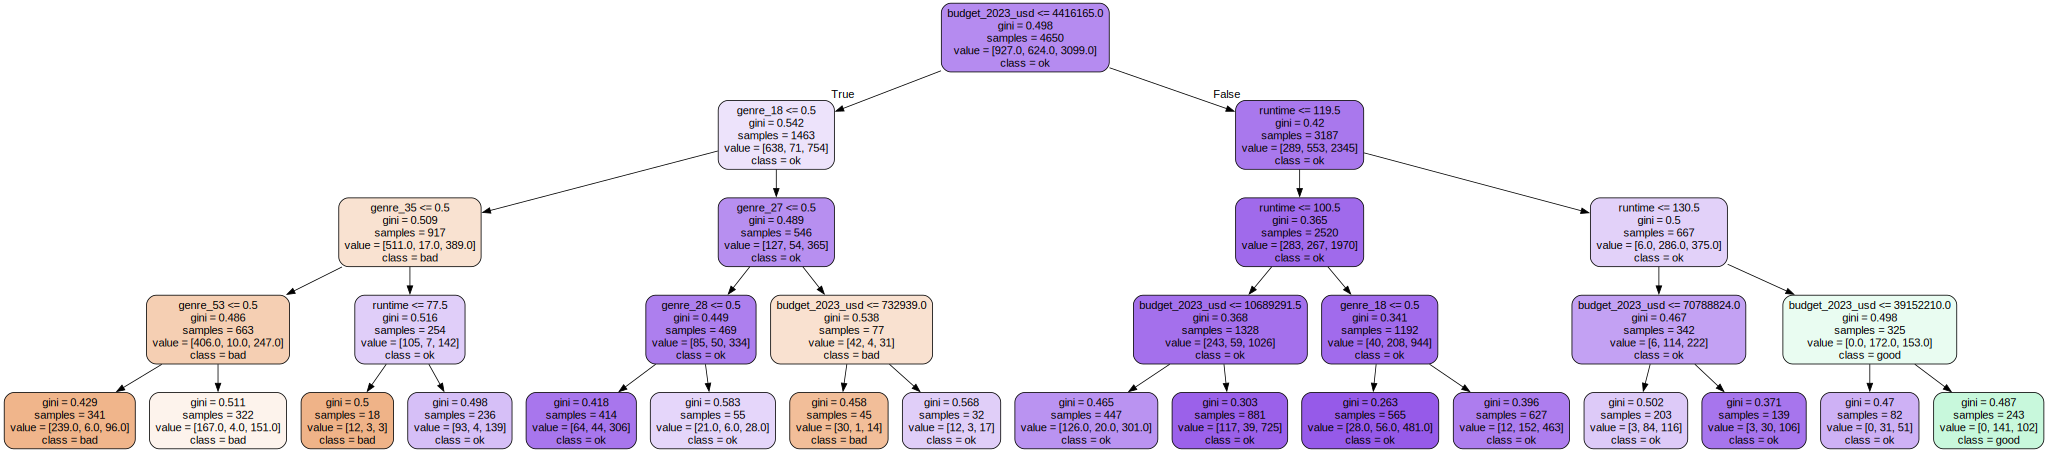

In [8]:
graph = graphviz.Source(dot_data)
graph

Model validation

In [9]:
# # Set the metrics
# scoring = 'accuracy'

In [10]:
# Predict the ratings of the test data
y_testp = model.predict(X_test)
y_testp

array([2, 2, 2, ..., 0, 2, 2])

In [11]:
y_test

5913    1
3392    1
1635    2
3339    2
4813    2
       ..
1617    2
2974    2
4145    2
6056    1
5350    2
Name: rating_encoded, Length: 1550, dtype: int64

In [12]:
# Calculated the accuracy of the model comparing the observed data and predicted data
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.7135483870967742


In [13]:
# Create confusion matrix
confusion_mat = confusion_matrix(y_test,y_testp)
confusion_mat

array([[160,   0, 171],
       [  3,  42, 162],
       [ 70,  38, 904]])

In [14]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,0,1,2
rating_encoded,,,
0,160,0,171
1,3,42,162
2,70,38,904
